In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers import Winsorizer

import mlflow

from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# !pip install feature_engine mlflow

In [3]:
data = pd.read_csv(r"titanic.csv")

In [4]:
data.sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S
273,274,0,1,"Natsch, Mr. Charles H",male,37.0,0,1,PC 17596,29.7,C118,C


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
def clean_data(df):
    return(
        df
        .rename(columns = str.lower)
        .drop(columns = ['passengerid','name', 'ticket', 'cabin'])
        .assign(
            family = lambda df_: df_['sibsp'] + df_['parch']
        )
        .drop(columns = ['sibsp', 'parch'])
    )
        

In [7]:
cleaned_data = clean_data(data)

In [8]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   fare      891 non-null    float64
 5   embarked  889 non-null    object 
 6   family    891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [9]:
# check null values

(
    cleaned_data
    .isna()
    .sum()
)
    

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
family        0
dtype: int64

# EDA

In [10]:
(
    cleaned_data
    .loc[:, 'survived']
    .value_counts(normalize = True)
)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [11]:
# Create box_plot

def create_boxplot(data, column_name, hue = None):
    sns.boxplot(data = data, y = column_name, hue = hue)

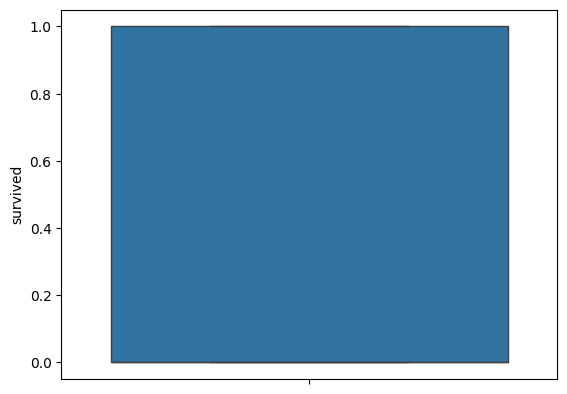

In [12]:
create_boxplot(cleaned_data, cleaned_data['survived'])

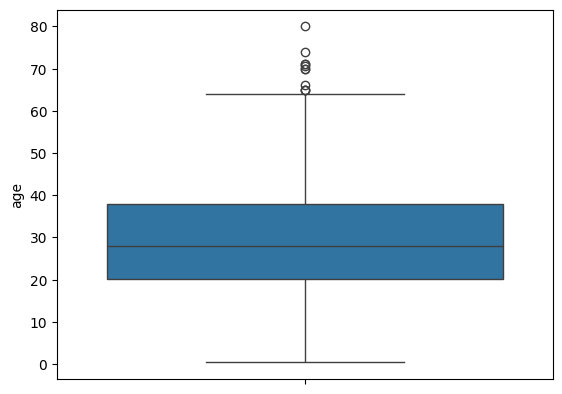

In [13]:
create_boxplot(cleaned_data, 'age')

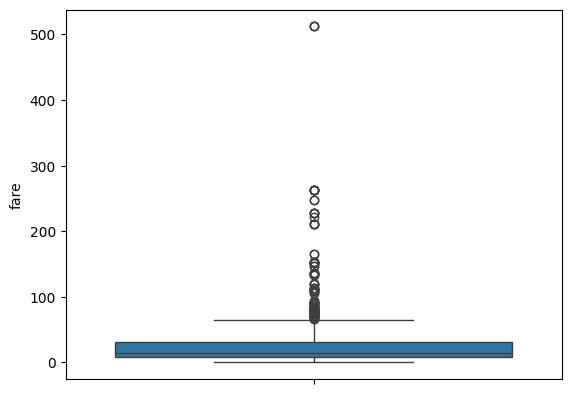

In [14]:
create_boxplot(cleaned_data, 'fare')

<Axes: xlabel='pclass', ylabel='count'>

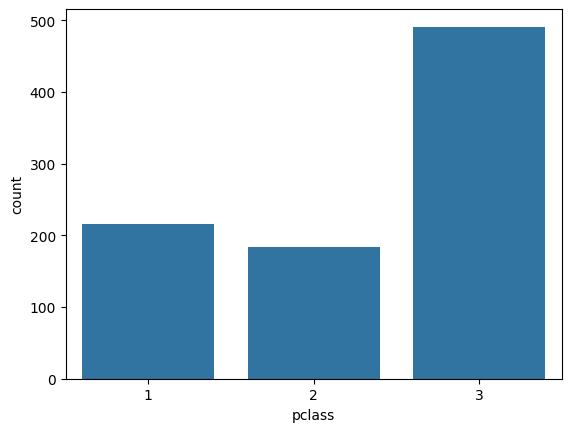

In [15]:
sns.countplot(data = cleaned_data, x = cleaned_data['pclass'])

<Axes: xlabel='sex', ylabel='count'>

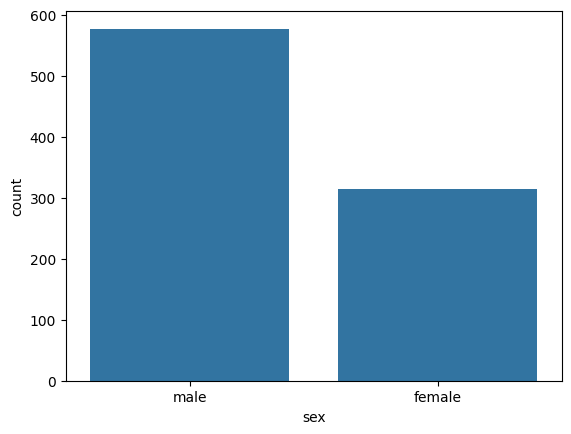

In [16]:
sns.countplot(data = cleaned_data, x = 'sex')

<Axes: xlabel='embarked', ylabel='count'>

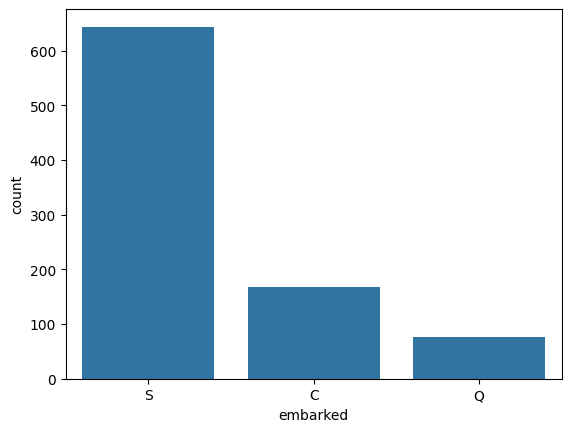

In [17]:
sns.countplot(data = cleaned_data, x = 'embarked')

# Fetaure Engineering

In [18]:
cleaned_data.sample(3)

,survived,pclass,sex,age,fare,embarked,family
713,0,3,male,29.0,9.4833,S,0
318,1,1,female,31.0,164.8667,S,2
129,0,3,male,45.0,6.9750,S,0


In [19]:
x = cleaned_data.drop(columns = ['survived'])
y = cleaned_data['survived']

In [20]:
x.sample(2)

,pclass,sex,age,fare,embarked,family
248,1,male,37.0,52.5542,S,2
776,3,male,NaN,7.7500,Q,0


In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
                                                   random_state = 42)

In [22]:
x_train.shape

(712, 6)

In [23]:
x_test.shape

(179, 6)

# Create pipeline

In [24]:
age_pipe = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'mean')),
    ('outliers', Winsorizer(capping_method = 'gaussian', fold = 3)),
    ('scale', StandardScaler())]
)

In [25]:
age_pipe

Pipeline(steps=[('impute', SimpleImputer()), ('outliers', Winsorizer(fold=3)),
                ('scale', StandardScaler())])

In [26]:
steps = [('outliers', Winsorizer(capping_method = 'iqr', fold = 1.5)), 
         ('scale', StandardScaler())]

In [27]:
fare_pipe = Pipeline(steps)

In [28]:
fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [29]:
cleaned_data.columns

Index(['survived', 'pclass', 'sex', 'age', 'fare', 'embarked', 'family'], dtype='object')

In [30]:
cleaned_data.embarked.value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [31]:
embarked_pipe = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method = 'count')),
    ('scale', MinMaxScaler())
]    
)

In [32]:
embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

# Columns Transformer

In [39]:
preprocessor = ColumnTransformer(transformers =[
    ('age', age_pipe, cleaned_data.age),
    ('fare', fare_pipe, cleaned_data.fare),
    ('embarked', embarked_pipe, cleaned_data.embarked),
    ('sex', OneHotEncoder(sparse_output= False, handle_unknown = 'ignore'), cleaned_data.sex),
    ('family', MinMaxScaler(),cleaned_data.family)
], remainder = 'passthrough', n_jobs= -1, force_int_remainder_cols= False    
)

In [34]:
preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: age, Length: 891, dtype: float64),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorize...
                                                 ('scale', MinMaxScaler())]),
                                 0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: embarked, Length: 891, dtype: object),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: sex, Length: 891, dtype: object),
                                ('family', MinMaxScaler(),
                                 0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: family, Length: 891, dtype: int64)])

In [35]:
cleaned_data.sample(5)

,survived,pclass,sex,age,fare,embarked,family
146,1,3,male,27.0,7.7958,S,0
390,1,1,male,36.0,120.0000,S,3
120,0,2,male,21.0,73.5000,S,2
336,0,1,male,29.0,66.6000,S,1
202,0,3,male,34.0,6.4958,S,0


In [42]:
preprocessor.fit_transform(x_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.244584,0.236751,1.0,0.0,1.0,0.0,1
733,-0.502078,-0.532339,1.0,0.0,1.0,0.0,2
382,0.196587,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.269190,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.821779,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.657337,-0.797799,1.0,1.0,0.0,0.0,3
270,0.002424,0.360798,1.0,0.0,1.0,0.0,1
860,0.895252,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.200743,2.016201,1.0,1.0,0.0,0.3,1


In [38]:
set_config(transform_output = 'pandas')

In [41]:
preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1,force_int_remainder_cols=False)


In [45]:
cleaned_data.family

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: family, Length: 891, dtype: int64

# Model Pipeline

In [46]:
preprocessor.get_params()

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer()), ('outliers', Winsorizer(fold=3)),
                   ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer()), ('outliers', Winsorizer(fold=3)),
                 ('scale', StandardScaler())]),
 'fare

In [47]:
model_params = {'bootstrap': True,
     'ccp_alpha': 0.0,
     'class_weight': None,
     'criterion': 'gini',
     'max_depth': 6,
     'max_features': 'sqrt',
     'max_leaf_nodes': None,
     'max_samples': 0.8,
     'min_impurity_decrease': 0.0,
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'min_weight_fraction_leaf': 0.0,
     'monotonic_cst': None,
     'n_estimators': 300,
     'n_jobs': -1,
     'oob_score': False,
     'random_state': 30,
     'verbose': 0,
     'warm_start': False}

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
model_pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(**model_params))
]                     
)

In [52]:
model_pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScale...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=30))])

In [53]:
y_pred = model_pipe.predict(x_test)

In [54]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred).item()
recall = recall_score(y_test, y_pred).item()
f1 = f1_score(y_test, y_pred).item()

In [55]:
metrics = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall,
    'f1_score' : f1
}

In [56]:
metrics

{'accuracy': 0.8100558659217877,
 'precision': 0.8125,
 'recall': 0.7027027027027027,
 'f1_score': 0.7536231884057971}

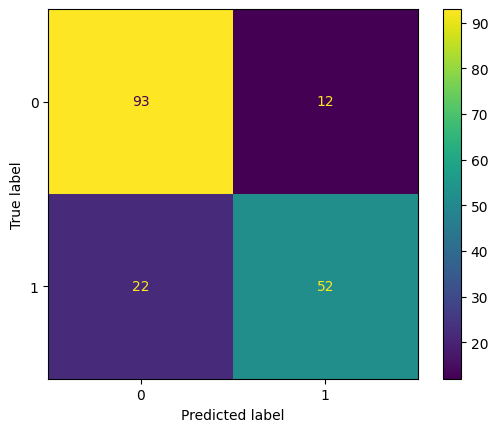

In [57]:
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# MLFlow  Tracking Code

In [58]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                     remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute', SimpleImputer()),
                                                    ('outliers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                                    ['fare']),
                                   ('embarked',
    

In [59]:
x_test.join(y_test)

,pclass,sex,age,fare,embarked,family,survived
709,3,male,NaN,15.2458,C,2,1
439,2,male,31.0,10.5000,S,0,0
840,3,male,20.0,7.9250,S,0,0
720,2,female,6.0,33.0000,S,1,1
39,3,female,14.0,11.2417,C,1,1
...,...,...,...,...,...,...,...
433,3,male,17.0,7.1250,S,0,0
773,3,male,NaN,7.2250,C,0,0
25,3,female,38.0,31.3875,S,6,1
84,2,female,17.0,10.5000,S,0,1


In [61]:
mlflow.set_tracking_uri('http://127.0.0.1:8080')

mlflow.set_experiment('mlflow_first_project')

with mlflow.start_run() as run:
    data_signature = mlflow.models.infer_signature(model_input = x_train, model_output=model_pipe.predict(x_train))
    mlflow.log_params(model_pipe.get_params())
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(sk_model = model_pipe, artifact_path = 'model.pkl', signature = data_signature)
    mlflow_uri = mlflow.get_artifact_uri('model.pkl')

    # mlflow.log_feature(cm.figure_, artifact_file = 'confusion_matrix.png')

C:\Users\Satish Kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run sassy-gull-680 at: http://127.0.0.1:8080/#/experiments/116393388801602687/runs/96823e5846ab4a0e9e44ca7f4db74840
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/116393388801602687
